# 神经风格迁移

In [0]:
import tensorflow as tf
from tensorflow import keras
from IPython import display

import matplotlib.pyplot as plt
import numpy as np

### 下载内容图像和风格图像

In [0]:
content_path = 'van-gogh.jpeg'
style_path = 'starry-night.jpg'

In [0]:
def load_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image

In [139]:
content_image = load_image(content_path)
style_image = load_image(style_path)
print(tf.shape(content_image))

tf.Tensor([361 268   3], shape=(3,), dtype=int32)


In [0]:
def resize_image(image, size=512):
    target_long_dim = size
    shape = tf.cast(tf.shape(image)[:-1], tf.float32)
    long_dim = max(shape)
    scale = target_long_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)

    image = tf.image.resize(image, new_shape)
    return image

In [0]:
content_image = resize_image(content_image)
style_image = resize_image(style_image)

Text(0.5, 1.0, 'style')

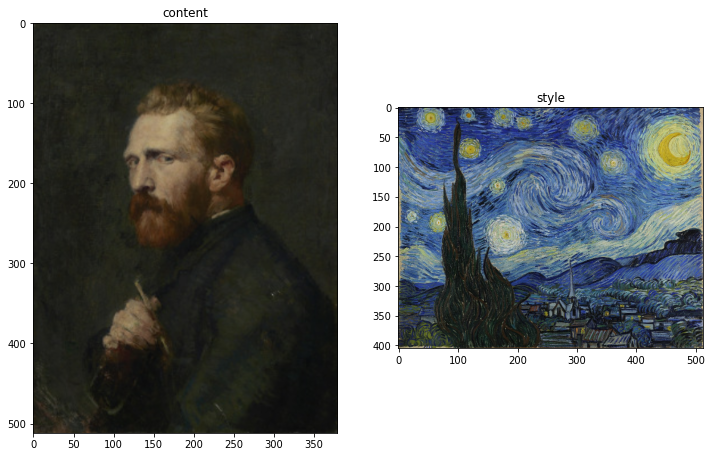

In [142]:
plt.subplot(1, 2, 1)
plt.imshow(content_image)
plt.title('content')

plt.subplot(1, 2, 2)
plt.imshow(style_image)
plt.title('style')

使用 VGG19 网络结构，这是一个已经预训练好的图像分类网络

打印 VGG19 网络层级

In [143]:
vgg = keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False
for layer in vgg.layers:
    print(layer.name)

input_8
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


提取网络中间层，即内容层和风格层，获得特征。

In [0]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

### 风格计算

Gram 矩阵:

$$ G_{cd}^l = \frac{\sum_{ij} F_{ijc}^l(x) F_{ijd}^l(x)}{IJ} $$

In [0]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations

将图片输入 VGG19，并输出 style 层和 content 层。

In [0]:
def image_to_style_content(image):

    image = image * 255

    style_model_outputs = [vgg.get_layer(name).output for name in style_layers]
    style_model = keras.Model([vgg.input], style_model_outputs)

    style_input = keras.applications.vgg19.preprocess_input(image)
    style_outputs = style_model(style_input)
    style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

    content_model_outputs = [vgg.get_layer(name).output for name in content_layers]
    content_model = keras.Model([vgg.input], content_model_outputs)

    content_input = keras.applications.vgg19.preprocess_input(image)
    content_outputs = content_model(content_input)

    style_dict = {name:value for name, value in zip(style_layers, style_outputs)}
    content_dict = {name:value for name, value in zip(content_layers, content_outputs)}

    return style_dict, content_dict

处理 image

In [0]:
style_image = style_image[tf.newaxis, :]
content_image = content_image[tf.newaxis, :]
content_image_var = tf.Variable(content_image)

In [0]:
style_targets, _ = image_to_style_content(style_image)
_, content_targets = image_to_style_content(content_image)

In [0]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [0]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [0]:
def style_content_loss(style_outputs, content_outputs):
    style_weight = 1e-2
    content_weight = 1e4

    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / len(style_layers)

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / len(content_layers)
    loss = style_loss + content_loss
    return loss

In [0]:
def train_step(image):
    with tf.GradientTape() as tape:
        style_outputs, content_outputs = image_to_style_content(image)
        loss = style_content_loss(style_outputs, content_outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

开始

In [0]:
# train_step(content_image_var)
# train_step(content_image_var)
# train_step(content_image_var)
# plt.imshow(content_image_var.read_value()[0])

Total time: 118.6


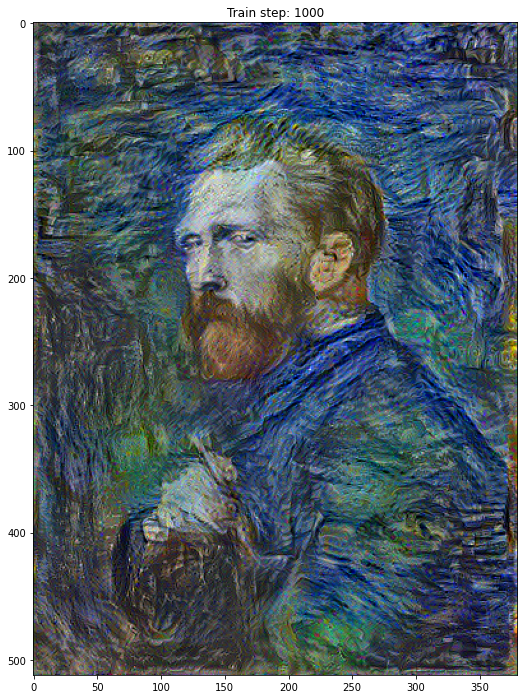

In [155]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(content_image_var)
        print(".", end='')
    display.clear_output(wait=True)
    plt.imshow(content_image_var.read_value()[0])
    plt.title("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))